# Stream Learning applied to 3W dataset

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook fits the 3W dataset to models of the River package.

# 2. Imports and Configurations

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import pickle
import graphviz
import river
from copy import deepcopy

from river import stream, feature_extraction as fx, compose, stats, preprocessing, tree, metrics, evaluate
from river import linear_model, optim, drift, anomaly, utils, ensemble, multiclass, datasets, time_series
from river import imblearn

import sklearn.model_selection
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
river.__version__

'0.14.0'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [3]:
class d3w():
    '''
    Class for managing Petrobras 3W dataset
    '''
    def __init__(self, path3w):
        self.path3w = path3w
        self.df = self.__load_df()
        return

    def __load_df(self):

        d = dict()
        d['origin'] = []
        d['well'] = []
        d['ts'] = []
        d['label'] = []
        d['path'] = []
        d['nlines'] = []
        for i in pathlib.Path(self.path3w).iterdir():
            if i.stem.isnumeric():
                print(i)
                label = int(i.stem)
                for fp in i.iterdir():
                    # Considers only csv files
                    if fp.suffix == ".csv":
                        d['well'].append(None)
                        d['ts'].append(None)
                        if (fp.stem.startswith("SIMULATED")):
                            d['origin'].append('S')
                        elif fp.stem.startswith("DRAWN"):
                            d['origin'].append('D')
                        else:
                            d['origin'].append('R')
                            if fp.stem.startswith('WELL'):
                                s = fp.stem
                                d['well'][-1] = int(s[5:10])
                                d['ts'][-1] = pd.Timestamp(year=int(s[11:15]), month=int(s[15:17]), day=int(s[17:19]), 
                                                           hour=int(s[19:21]), minute=int(s[21:23]), second=int(s[23:25]))
                        d['label'].append(label)
                        d['path'].append(fp)
                        d['nlines'].append(self.file_len(fp)-1)
                        
        return pd.DataFrame(d)
    
    def split(self, real=True, simul=True, drawn=True, well=None, label=None, test_size=0.2, val_size=0.1, sample_n=None):
        
        tmp0_df = self.get_df(real, simul, drawn, well, label)
        
        if sample_n is not None:
            N = len(tmp0_df.index)
            if N > sample_n:
                ds_list = []
                for i, ni in tmp0_df.groupby('label').count().nlines.items():
                    ns = ni*sample_n//N
                    ds_list.append(tmp0_df[tmp0_df.label == i].sample(n=ns, random_state=200560))
                tmp0_df = pd.concat(ds_list)            
        
        tmp_df, test_df = sklearn.model_selection.train_test_split(tmp0_df, 
                                                        test_size=test_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp0_df['label'])
        
        if val_size == 0:
            print('Instances Train: {}  Test: {}'.format(len(tmp_df.index), 
                                                         len(test_df.index)))
            return tmp_df.reset_index(drop=True),\
                   test_df.reset_index(drop=True)
        
        train_df, val_df = sklearn.model_selection.train_test_split(tmp_df, test_size=val_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp_df['label'])
        print('Instances Train: {}  Test: {}  Validation: {}'.format(len(train_df.index), 
                                                                     len(test_df.index), 
                                                                     len(val_df.index)))
        
        return train_df.reset_index(drop=True),\
               test_df.reset_index(drop=True),\
               val_df.reset_index(drop=True)
    
    def file_len(self, filename):
        j = 0
        with open(filename) as f:
            for i, x in enumerate(f):
                if x.strip() == '':
                    j += 1
        return i + 1 - j
    
    def get_df(self, real=True, simul=True, drawn=True, well=None, label=None):

        if label is not None:
            if not isinstance(label, list):
                label = [label]
            return self.df[self.df.label.isin(label)].drop(columns=['origin', 'well']).reset_index(drop=True)
            
        if well is not None:
            return self.df[self.df['well']==well].drop(columns=['origin', 'well']).reset_index(drop=True)
        
        sel = []
        if real:
            sel.append('R')
        if simul:
            sel.append('S')
        if drawn:
            sel.append('D')
        if sel:
            return self.df[self.df['origin'].isin(sel)].drop(columns=['origin', 'well']).reset_index(drop=True)
    
    @property
    def all(self):
        return self.df.drop(columns=['origin'])
    @property
    def real(self):
        return self.df[self.df['origin']=='R'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def simul(self):
        return self.df[self.df['origin']=='S'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def drawn(self):
        return self.df[self.df['origin']=='D'].drop(columns=['origin']).reset_index(drop=True)


In [4]:
if pathlib.Path('dset_tfm1.pkl').exists():
  with open('dset_tfm1.pkl', 'rb') as f:
    dset = pickle.load(f)
else:
    dset = d3w('../dataset')
    with open('dset_tfm1.pkl', 'wb') as f:
      pickle.dump(dset, f)

Subset for labels 0 (Normal conditions) and 2 (SPURIOUS CLOSURE OF DHSV).

In [5]:
flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
categories=[0, 4]

data_df = dset.get_df(label=[0, 4])
data_df = data_df.sample(frac=1, random_state=200560).reset_index(drop=True)
data_df[:10]

,ts,label,path,nlines
0,2017-08-12 23:00:00,0,..\dataset\0\WELL-00005_20170812230000.csv,10765
1,2017-04-03 14:00:00,0,..\dataset\0\WELL-00005_20170403140000.csv,17913
2,2014-01-25 12:00:16,4,..\dataset\4\WELL-00002_20140125120016.csv,7185
3,2017-04-01 22:01:56,0,..\dataset\0\WELL-00005_20170401220156.csv,17855
4,2017-03-09 12:01:56,0,..\dataset\0\WELL-00002_20170309120156.csv,17885
5,2017-06-27 07:00:50,4,..\dataset\4\WELL-00005_20170627070050.csv,7151
6,2017-08-07 09:00:00,0,..\dataset\0\WELL-00002_20170807090000.csv,17488
7,2017-08-18 06:02:10,0,..\dataset\0\WELL-00008_20170818060210.csv,17680
8,2017-02-11 19:01:29,0,..\dataset\0\WELL-00002_20170211190129.csv,17912
9,2017-08-15 17:00:00,0,..\dataset\0\WELL-00005_20170815170000.csv,10658


Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.  

            TYPE OF UNDESIRABLE EVENT       WINDOW SIZE   
		
            1 - ABRUPT INCREASE OF BSW       12h 
            2 – SPURIOUS CLOSURE OF DHSV     5min–20min 
            3 – SEVERE SLUGGING         	 5h 
            4 – FLOW INSTABILITY             15min 
            5 – RAPID PRODUCTIVITY LOSS 	 12h 
            6 – QUICK RESTRICTION IN PCK     15min 
            7 – SCALING IN PCK               72h 
            8 – HYDRATE IN PRODUCTION LINE   30min–5h 


In [6]:
class CustomGen():
    '''instance generator for the 3W files in dset'''
    
    def __init__(self, dset, flist, target, scaleb=False, out_time=False, ifileb=False, min_std=None):
        self.dset = dset
        self.flist = flist
        self.target = target
        self.scaleb = scaleb
        self.out_time = out_time
        self.ifileb = ifileb
        self.nfiles = len(dset.index)
        self.min_std = min_std
        return
    
    def todataframe(self):
        ds_list = []
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            ds['ifile'] = ifile
            
            ds_list.append(ds)
        return pd.concat(ds_list, ignore_index=True)
    
    def iter(self, max_n=None):
        n = 0
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            if self.scaleb:
                np.seterr(divide='ignore', invalid='ignore')
                dfd = self.scale(ds[self.flist]).to_dict(orient='records')
                np.seterr(divide='warn', invalid='warn')
            else:
                dfd = ds[self.flist].to_dict(orient='records')
            for i, x in enumerate(dfd):
                #assert isinstance(df.iloc[i][self.target], np.int32), 'class not an integer!'
                result = []
                if self.ifileb:
                    result.append(ifile)
                if self.out_time:
                    result.append(ds.index[i])
                yield result + [x, ds.iloc[i][self.target]]
                n += 1
                if max_n is not None and n > max_n:
                    break
            if max_n is not None and n > max_n:
                break

        return
    
    def scale(self, df):
        xm = df[self.flist].mean()
        sm = df[self.flist].std()
        if self.min_std is not None:
            sm = pd.concat([sm, pd.Series(self.min_std)]).groupby(level=0).max()[sm.index]
        return (df[self.flist]-xm)/sm

    def plot(self, ifiles):
        
        if isinstance(ifiles, list):
            n_files = len(ifiles)
        else:
            ifiles = [ifiles]
            n_files = 1
        
        fig, axs = plt.subplots(nrows=len(self.flist)+1, ncols=n_files, figsize=(10, 12), sharex='col')
        axs = axs.flatten()

        dss = []
        supt = ''
        for i_col, i_f in enumerate(ifiles):
        
            dss.append(pd.read_csv(self.dset['path'][i_f], parse_dates=["timestamp"]))
            #ds = ds.drop_duplicates(subset='timestamp', keep="last").sort_values(by=['timestamp']).reset_index(drop=True)
            if np.any(dss[i_col][self.target].isna()):
                ds[i_col][self.target] = ds[i_col][self.target].fillna(method='ffill')
            
            supt += str(self.dset['path'][i_f])
            if i_col != n_files-1:
                supt += '\n'
            fig.suptitle(supt)

            for i, vs in enumerate(self.flist):
                axs[i*n_files+i_col].plot(dss[i_col].timestamp[::60], dss[i_col][vs][::60])
                if i_col == 0:
                    axs[i*n_files+i_col].set_ylabel(vs)
        
            id = np.argsort(dss[i_col][self.target])
            t = [dss[i_col].timestamp[i] for i in id][::60]
            y = [str(dss[i_col][self.target][i]) for i in id][::60]
        
            axs[(i+1)*n_files+i_col].scatter(t, y, marker='.')
        
            axs[(i+1)*n_files+i_col].xaxis.set_tick_params(rotation=45)
            
            if i_col == 0:
                axs[(i+1)*n_files+i_col].set_ylabel(self.target)
        
            axs[(i+1)*n_files+i_col].set_xlabel('Date')
            
        
        for ax in axs.flatten():
            ax.grid(visible=True)

        return fig  


In [7]:
gen = CustomGen(data_df, flist, 'class', scaleb=True, out_time=True, ifileb=True)
n = 0
for i, time, x, t in gen.iter():
    if i == 3:
        print(i, time, x, t)
        n += 1
        if n > 3:
            break

3 2017-04-01 22:01:00 {'P-PDG': nan, 'P-TPT': 1.9243725461540124, 'T-TPT': -0.3330856553107126, 'P-MON-CKP': -0.4511122705540669, 'T-JUS-CKP': -0.3283109092285841, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2017-04-01 22:02:00 {'P-PDG': nan, 'P-TPT': 0.7275379822987611, 'T-TPT': 0.02094933198801685, 'P-MON-CKP': -1.0671870809793182, 'T-JUS-CKP': -0.31370203967322513, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2017-04-01 22:03:00 {'P-PDG': nan, 'P-TPT': 0.33080562489434834, 'T-TPT': -0.19237888322405589, 'P-MON-CKP': -0.5733029869283329, 'T-JUS-CKP': -0.2857244422874145, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2017-04-01 22:04:00 {'P-PDG': nan, 'P-TPT': -0.11324256576726108, 'T-TPT': -1.0432492210608963, 'P-MON-CKP': -0.8678185518363063, 'T-JUS-CKP': -0.25784605624171125, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0


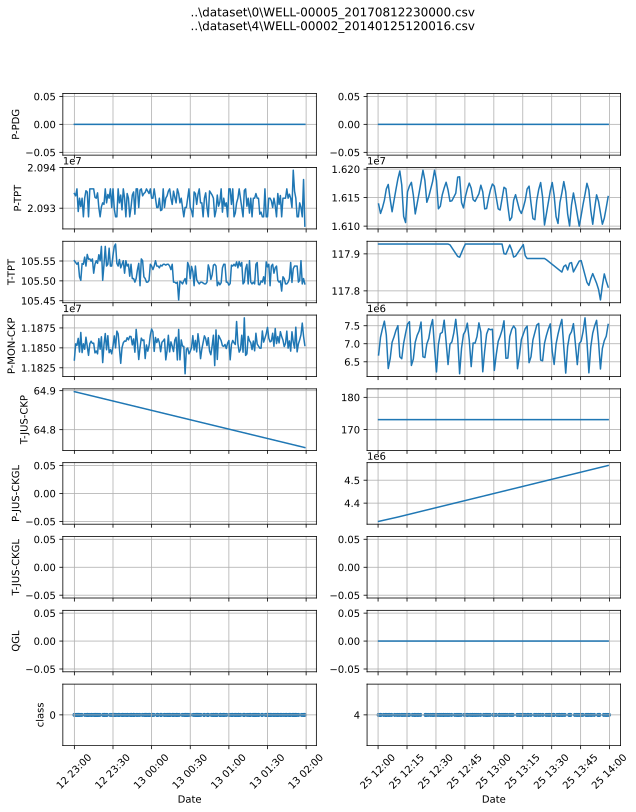

In [8]:
gen.plot([0,2])
plt.savefig('plot.jpg')

### Ajuste del Modelo  

Fit the subset to River models:
- A time window of 15min is used for calculating the rolling statistics:  
     mean, std, min, max  
  of every feature
- The standard scaler and the rolling statistics are reinitialized every new time series
- The fit starts after a warming period (equal to the rolling window size)

In [9]:
def fit_model(data_df, flist, target, window_size: int, model0, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = int(window_size)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    accuracies = []
    ifiles = []
    i_s = []
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            lastfile = ifile
            j = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)

            if not EvalB:
                model.learn_one(xd, y)

            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            accuracies.append(report.get())
            ifiles.append(ifile)
            i_s.append(i)

    print('\n', report)
    print('\n', report0)
    if dfB:
        return i_s, ys, y_preds, accuracies, report, ifiles, model, pd.DataFrame(df_list)
    return i_s, ys, y_preds, accuracies, report, ifiles, model

In [11]:
%%time

#model =  tree.HoeffdingTreeClassifier(delta=1.E-4)
#model =  multiclass.OneVsOneClassifier(linear_model.PAClassifier(C=1.0, mode=1))
#model = multiclass.OneVsOneClassifier(linear_model.ALMAClassifier())
Basemodel = imblearn.RandomOverSampler(tree.HoeffdingTreeClassifier(delta=1.E-4),
            desired_dist={0: 0.5, 4: 0.5}, seed=200560)
model = deepcopy(Basemodel)
# model = imblearn.RandomOverSampler(multiclass.OneVsOneClassifier(linear_model.ALMAClassifier(alpha=0.85, B=1./0.85)),
#                                    desired_dist={0: 0.5, 4: 0.5}, seed=200560)

flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
window_size = 30

i_s, ys, y_preds, accuracies, reports, ifiles, model, df = fit_model(data_df, flist, 'class', window_size,
                                                                     model, dfB=True, EvalB=False)
i_se, yse, y_predse, accuraciese, reportse, _, _ = fit_model(data_df, flist, 'class', window_size, 
                                                                    model, dfB=False, EvalB=True)    

files learned  941 / 941
 BalancedAccuracy: 99.36%

            Precision   Recall   F1       Support  
                                                  
     0.0      99.79%   99.68%   99.74%    149201  
     4.0      98.50%   99.03%   98.76%     31501  
                                                  
   Macro      99.15%   99.36%   99.25%            
   Micro      99.57%   99.57%   99.57%            
Weighted      99.57%   99.57%   99.57%            

                 99.57% accuracy                  
files learned  941 / 941
 BalancedAccuracy: 59.34%

            Precision   Recall   F1       Support  
                                                  
     0.0      90.61%   36.70%   52.24%    149201  
     4.0      21.47%   81.98%   34.03%     31501  
                                                  
   Macro      56.04%   59.34%   43.14%            
   Micro      44.60%   44.60%   44.60%            
Weighted      78.56%   44.60%   49.07%            

                 44.60% a

In [11]:
model

RandomOverSampler (
  classifier=HoeffdingTreeClassifier (
    grace_period=200
    max_depth=inf
    split_criterion="info_gain"
    delta=0.0001
    tau=0.05
    leaf_prediction="nba"
    nb_threshold=0
    nominal_attributes=None
    splitter=GaussianSplitter (
      n_splits=10
    )
    binary_split=False
    max_size=100.
    memory_estimate_period=1000000
    stop_mem_management=False
    remove_poor_attrs=False
    merit_preprune=True
  )
  desired_dist={0: 0.5, 4: 0.5}
  seed=200560
)

In [12]:
from sklearn.metrics import classification_report
#np.unique(y_preds, return_counts=True)
print(classification_report(ys, y_preds))

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97    149201
         4.0       0.80      0.92      0.86     31501

    accuracy                           0.95    180702
   macro avg       0.89      0.94      0.91    180702
weighted avg       0.95      0.95      0.95    180702



In [13]:
%%time

# Variable Importance

from sklearn.ensemble import RandomForestClassifier

f_list = []
for f in df.columns:
    n = sum(df[f].isnull())
    print(f, n)
    if n == 0:
        f_list.append(f)
f_list = f_list[:-1]

forest = RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=200560)
forest.fit(df[f_list], df['class'])
print('mean accuracy Random Forest: ', forest.score(df[f_list], df['class']))
varImp = {'var': f_list, 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp).sort_values(['varImp'], ascending=False)
print(varImp)

varImp = {'var': [x[0] for x in [x.split('_') for x in f_list]], 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp)
varImp = varImp.groupby('var').sum().sort_values(['varImp'], ascending=False).reset_index()
varImp

P-PDG_rmean 0
P-PDG_rSEM 0
P-PDG_rMax 0
P-PDG_rMin 0
P-TPT_rmean 0
P-TPT_rSEM 0
P-TPT_rMax 0
P-TPT_rMin 0
T-TPT_rmean 0
T-TPT_rSEM 0
T-TPT_rMax 0
T-TPT_rMin 0
P-MON-CKP_rmean 15207
P-MON-CKP_rSEM 15207
P-MON-CKP_rMax 15207
P-MON-CKP_rMin 15207
T-JUS-CKP_rmean 22198
T-JUS-CKP_rSEM 22198
T-JUS-CKP_rMax 22198
T-JUS-CKP_rMin 22198
class 0
P-JUS-CKGL_rmean 53419
P-JUS-CKGL_rSEM 53419
P-JUS-CKGL_rMax 53419
P-JUS-CKGL_rMin 53419
QGL_rmean 44739
QGL_rSEM 44739
QGL_rMax 44739
QGL_rMin 44739
mean accuracy Random Forest:  0.9992861174751801
            var    varImp
5    P-TPT_rSEM  0.162076
6    P-TPT_rMax  0.153975
7    P-TPT_rMin  0.112834
4   P-TPT_rmean  0.091706
11   T-TPT_rMin  0.086988
10   T-TPT_rMax  0.082261
9    T-TPT_rSEM  0.070871
8   T-TPT_rmean  0.063665
2    P-PDG_rMax  0.052205
1    P-PDG_rSEM  0.050203
0   P-PDG_rmean  0.048660
3    P-PDG_rMin  0.024558
CPU times: total: 4.2 s
Wall time: 6.37 s


,var,varImp
0,P-TPT,0.520590
1,T-TPT,0.303784
2,P-PDG,0.175625


In [14]:
# Random Forest on validation set
print(classification_report(df['class'], forest.predict((df[f_list]))))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    149201
         4.0       1.00      1.00      1.00     31501

    accuracy                           1.00    180702
   macro avg       1.00      1.00      1.00    180702
weighted avg       1.00      1.00      1.00    180702



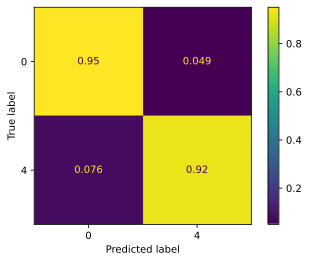

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay(confusion_matrix(ys, y_preds, labels=categories, normalize='true'), 
                       display_labels=categories).plot()

## Drift test

In [16]:
def plot_acc(i_s, i_sD, accuracies, accuraciesD, dr, first, second):
    plt.figure(figsize=(10,4))

    plt.ylabel('Accuracies')
    plt.plot(i_s, accuracies, label=first)
    plt.plot(i_sD, accuraciesD, label=second)
    plt.legend(loc="lower right")
    plt.title('Accuracies')
    m, M = np.quantile(accuracies, [0.05, 0.95])
    m, M = round(m-0.05, 1), round(M+0.05, 1)    
    m1, M1 = np.quantile(accuraciesD, [0.05, 0.95])
    m1, M1 = round(m1-0.05, 1), round(M1+0.05, 1)    
    plt.ylim([min(m, m1), max(M, M1)])
#     plt.grid()
    
    res = dr.to_df()
    res0 = res[res.change == True].i.reset_index(drop=True)
    for i in res0:
        plt.axvline(x=i, c='green', alpha=0.25)
    res0 = res[res.new_model == True].i.reset_index(drop=True)
    for i in res0:
        plt.axvline(x=i, c='red')
    plt.show()
    return

In [17]:
class drift_reg:
    def __init__(self):
        self.d = {'i': [], 'n': [], 'ifile': [], 'label': [], 'y': [], 'path': [], 'warn': [], 
                  'change': [], 'new_model': [], 'origin': [], 'well': []}
        return
    def append(self, i, n, ifile, label, y, path, warn, change, new_model):
        self.d['i'].append(i)
        self.d['n'].append(n)
        self.d['ifile'].append(ifile)
        self.d['label'].append(label)
        self.d['y'].append(int(y))
        self.d['path'].append(path)
        self.d['warn'].append(warn)
        self.d['change'].append(change)
        self.d['new_model'].append(new_model)
        self.d['well'].append(None)
        if (path.stem.startswith("SIMULATED")):
            self.d['origin'].append('S')
        elif path.stem.startswith("DRAWN"):
            self.d['origin'].append('D')
        else:
            self.d['origin'].append('R')
            if path.stem.startswith('WELL'):
                self.d['well'][-1] = int(path.stem[5:10])


        return
    def to_df(self):
        return pd.DataFrame(self.d)
    def get_changes(self):
        return sum(self.d['change'])

In [18]:
def fit_modelD(data_df, flist, target, window_size: int, model0, dr, drd0, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
        n_model = 0
#     drd = deepcopy(drd0)
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = int(window_size)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    accuracies = []
    ifiles = []
    i_s = []
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            lastfile = ifile
            j = 0
            print_warning = True
            drd = deepcopy(drd0)
            n = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)
            _ = drd.update(y != y_pred)
            warn = change = False
            if hasattr(drd, "warning_detected") and drd.warning_detected and print_warning:
                warn = True
                print(f"\nWarning detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
                print_warning = False
                dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change, False)
            if drd.drift_detected:
                change = True
                print(f"\nChange detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
                print_warning = True
                if n_model > 10000:
                    model = deepcopy(model0) #model reinitialization
                    j = 0
                    n_model = 0
                    print('*** model reinitializated ***')
                    dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change, True)
                else:
                    dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change, False)
                    
            n += 1

            if not EvalB:
                model.learn_one(xd, y)
                n_model += 1

            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            accuracies.append(report.get())
            ifiles.append(ifile)
            i_s.append(i)
            
    print('\n', report)
    print('\n', report0)
    if dfB:
        return i_s, ys, y_preds, accuracies, report, ifiles, model, pd.DataFrame(df_list)
    return i_s, ys, y_preds, accuracies, report, ifiles, model

### ADWIN

In [19]:
modelD = deepcopy(Basemodel)

#delta=0.002, clock=32, max_buckets=5, min_window_length=5, grace_period=10
drd = drift.ADWIN(delta=0.002, clock=30, min_window_length=45, grace_period=120)
dr_ADWIN = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                      modelD, dr_ADWIN, drd, dfB=False, EvalB=False)    

files learned  9 / 941
Change detected at index 2205 269, ifile 8, label 0 0.0 WELL-00002_20170211190129
files learned  30 / 941
Change detected at index 7044 269, ifile 29, label 0 0.0 WELL-00006_20170506020103
files learned  37 / 941
Change detected at index 8425 209, ifile 36, label 0 0.0 WELL-00008_20170615140310
files learned  38 / 941
Change detected at index 8779 269, ifile 37, label 0 0.0 WELL-00002_20170212100203
files learned  42 / 941
Change detected at index 9591 239, ifile 41, label 0 0.0 WELL-00001_20170525190000
files learned  85 / 941
Change detected at index 20026 269, ifile 84, label 0 0.0 WELL-00001_20170823050000
*** model reinitializated ***
files learned  108 / 941
Change detected at index 25469 209, ifile 107, label 0 0.0 WELL-00006_20170817230000
files learned  118 / 941
Change detected at index 27591 239, ifile 117, label 0 0.0 WELL-00006_20170208040124
files learned  126 / 941
Change detected at index 29423 209, ifile 125, label 0 0.0 WELL-00002_20170619030032

In [20]:
print('Number of drift points detected: {}'.format(dr_ADWIN.get_changes()))

Number of drift points detected: 36


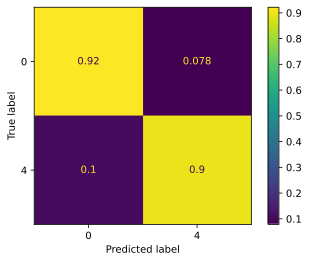

In [21]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot()

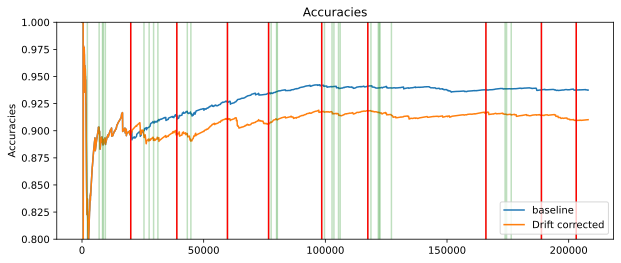

In [22]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_ADWIN, 'baseline', 'Drift corrected')

### DDM

In [23]:
modelD = imblearn.RandomOverSampler(tree.HoeffdingTreeClassifier(delta=1.E-4),
         desired_dist={0: 0.5, 4: 0.5}, seed=200560)

drd = drift.DDM(warm_start=250, warning_threshold=2.0, drift_threshold=3.0) #warm_start=30, warning_threshold=2.0, drift_threshold=3.0
dr_DDM = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                      modelD, dr_DDM, drd, dfB=False, EvalB=False)    

files learned  30 / 941
Warning detected at index 7037 262, ifile 29, label 0 0.0 WELL-00006_20170506020103
files learned  45 / 941
Change detected at index 10332 261, ifile 44, label 0 0.0 WELL-00002_20170214220322
files learned  46 / 941
Warning detected at index 10622 253, ifile 45, label 0 0.0 WELL-00008_20170701140135

Change detected at index 10625 256, ifile 45, label 0 0.0 WELL-00008_20170701140135
files learned  63 / 941
Warning detected at index 15162 253, ifile 62, label 0 0.0 WELL-00002_20170624160054

Change detected at index 15166 257, ifile 62, label 0 0.0 WELL-00002_20170624160054
*** model reinitializated ***
files learned  112 / 941
Warning detected at index 26365 266, ifile 111, label 0 0.0 WELL-00006_20170819050000
files learned  123 / 941
Warning detected at index 28757 265, ifile 122, label 0 0.0 WELL-00006_20170827180146
files learned  147 / 941
Warning detected at index 34801 265, ifile 146, label 0 0.0 WELL-00005_20170401170000
files learned  209 / 941
Warning 

In [24]:
print('Number of drift points detected: {}'.format(dr_DDM.get_changes()))

Number of drift points detected: 15


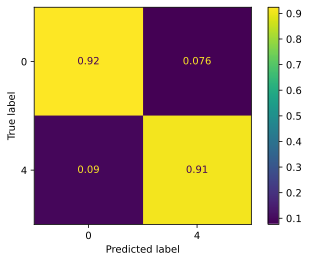

In [25]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot()

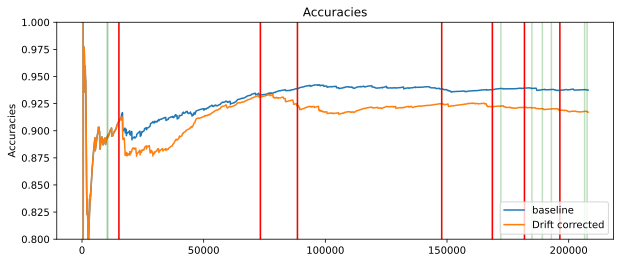

In [26]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_DDM, 'baseline', 'Drift corrected')

### EDDM

In [27]:
modelD = deepcopy(Basemodel)

drd = drift.EDDM(warm_start=120, alpha=0.95, beta=0.9) #warm_start=30, alpha=0.95, beta=0.9
dr_EDDM = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                      modelD, dr_EDDM, drd, dfB=False, EvalB=False)    

files learned  192 / 941
Change detected at index 44738 205, ifile 191, label 0 0.0 WELL-00008_20170817100246
*** model reinitializated ***
files learned  260 / 941
Warning detected at index 59682 148, ifile 259, label 0 0.0 WELL-00008_20170612040000

Change detected at index 59792 258, ifile 259, label 0 0.0 WELL-00008_20170612040000
*** model reinitializated ***
files learned  336 / 941
Change detected at index 76681 268, ifile 335, label 0 0.0 WELL-00006_20170209050042
*** model reinitializated ***
files learned  563 / 941
Warning detected at index 125721 176, ifile 562, label 0 0.0 WELL-00008_20170703060123

Change detected at index 125736 191, ifile 562, label 0 0.0 WELL-00008_20170703060123
*** model reinitializated ***
files learned  641 / 941
Warning detected at index 141997 173, ifile 640, label 0 0.0 WELL-00008_20170610220246

Change detected at index 142022 198, ifile 640, label 0 0.0 WELL-00008_20170610220246
*** model reinitializated ***
files learned  668 / 941
Change det

In [28]:
print('Number of drift points detected: {}'.format(dr_EDDM.get_changes()))

Number of drift points detected: 12


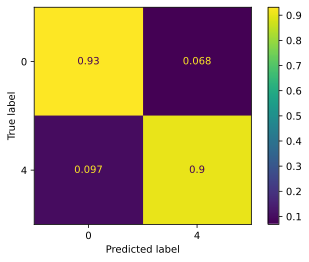

In [29]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot()

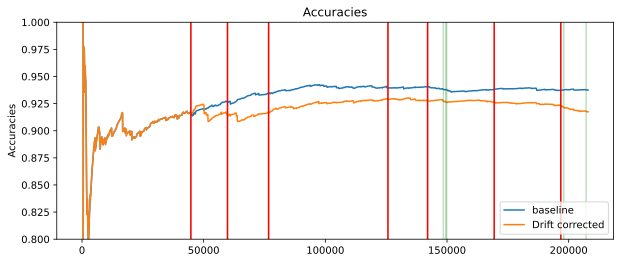

In [30]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_EDDM, 'baseline', 'Drift corrected')

### HDDM_A

In [31]:
modelD = deepcopy(Basemodel)

drd = drift.HDDM_A(drift_confidence=0.00005, warning_confidence=0.0001) # drift_confidence=0.001, warning_confidence=0.005
dr_HDDM_A = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                modelD, dr_HDDM_A, drd, dfB=False, EvalB=False)    

files learned  5 / 941
Warning detected at index 1036 108, ifile 4, label 0 0.0 WELL-00002_20170309120156

Change detected at index 1037 109, ifile 4, label 0 0.0 WELL-00002_20170309120156
files learned  7 / 941
Warning detected at index 1543 194, ifile 6, label 0 0.0 WELL-00002_20170807090000

Change detected at index 1544 195, ifile 6, label 0 0.0 WELL-00002_20170807090000
files learned  11 / 941
Warning detected at index 2461 47, ifile 10, label 0 0.0 WELL-00002_20170613120000

Change detected at index 2462 48, ifile 10, label 0 0.0 WELL-00002_20170613120000
files learned  30 / 941
Warning detected at index 6954 179, ifile 29, label 0 0.0 WELL-00006_20170506020103

Change detected at index 6985 210, ifile 29, label 0 0.0 WELL-00006_20170506020103
files learned  33 / 941
Warning detected at index 7440 65, ifile 32, label 4 4.0 WELL-00001_20170317080000

Change detected at index 7441 66, ifile 32, label 4 4.0 WELL-00001_20170317080000
files learned  37 / 941
Warning detected at index 

files learned  241 / 941
Change detected at index 55419 187, ifile 240, label 0 0.0 WELL-00006_20170509100135
files learned  258 / 941
Warning detected at index 59175 58, ifile 257, label 4 4.0 WELL-00004_20140805200046
files learned  259 / 941
Warning detected at index 59303 65, ifile 258, label 0 0.0 WELL-00008_20170817150222

Change detected at index 59304 66, ifile 258, label 0 0.0 WELL-00008_20170817150222

Warning detected at index 59452 214, ifile 258, label 0 0.0 WELL-00008_20170817150222

Change detected at index 59453 215, ifile 258, label 0 0.0 WELL-00008_20170817150222
*** model reinitializated ***
files learned  272 / 941
Change detected at index 62155 102, ifile 271, label 0 0.0 WELL-00001_20170824210000
files learned  276 / 941
Change detected at index 63020 69, ifile 275, label 0 0.0 WELL-00002_20170405090000

Warning detected at index 63113 162, ifile 275, label 0 0.0 WELL-00002_20170405090000

Change detected at index 63114 163, ifile 275, label 0 0.0 WELL-00002_20170

files learned  904 / 941
Change detected at index 200184 70, ifile 903, label 0 0.0 WELL-00002_20170406050000

Warning detected at index 200293 179, ifile 903, label 0 0.0 WELL-00002_20170406050000

Change detected at index 200294 180, ifile 903, label 0 0.0 WELL-00002_20170406050000
files learned  913 / 941
Warning detected at index 201950 37, ifile 912, label 4 4.0 WELL-00001_20170319180033

Change detected at index 201951 38, ifile 912, label 4 4.0 WELL-00001_20170319180033
*** model reinitializated ***
files learned  936 / 941
Change detected at index 206775 64, ifile 935, label 0 0.0 WELL-00005_20170814110000
files learned  939 / 941
Warning detected at index 207552 252, ifile 938, label 0 0.0 WELL-00002_20170215080056

Change detected at index 207553 253, ifile 938, label 0 0.0 WELL-00002_20170215080056
files learned  941 / 941
 BalancedAccuracy: 89.93%

            Precision   Recall   F1       Support  
                                                  
     0.0      97.29%   9

In [32]:
print('Number of drift points detected: {}'.format(dr_HDDM_A.get_changes()))

Number of drift points detected: 152


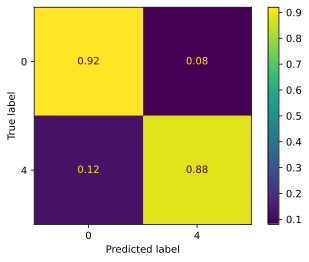

In [33]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot()

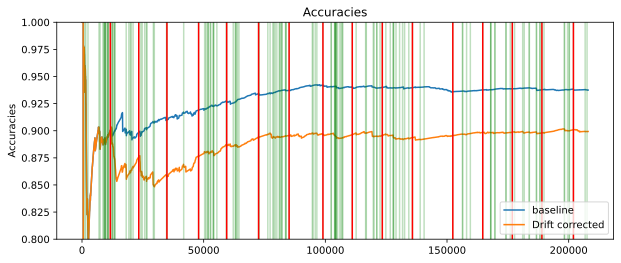

In [34]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_HDDM_A, 'baseline', 'Drift corrected')

### HDDM_W

In [35]:
modelD = deepcopy(Basemodel)

drd = drift.HDDM_W(drift_confidence=0.0001, warning_confidence=0.0005) # drift_confidence=0.001, warning_confidence=0.005
dr_HDDM = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                            modelD, dr_HDDM, drd, dfB=False, EvalB=False)    

files learned  5 / 941
Warning detected at index 1045 117, ifile 4, label 0 0.0 WELL-00002_20170309120156
files learned  7 / 941
Warning detected at index 1545 196, ifile 6, label 0 0.0 WELL-00002_20170807090000

Change detected at index 1547 198, ifile 6, label 0 0.0 WELL-00002_20170807090000
files learned  11 / 941
Warning detected at index 2475 61, ifile 10, label 0 0.0 WELL-00002_20170613120000

Change detected at index 2477 63, ifile 10, label 0 0.0 WELL-00002_20170613120000
files learned  30 / 941
Warning detected at index 6979 204, ifile 29, label 0 0.0 WELL-00006_20170506020103

Change detected at index 6980 205, ifile 29, label 0 0.0 WELL-00006_20170506020103
files learned  33 / 941
Warning detected at index 7444 69, ifile 32, label 4 4.0 WELL-00001_20170317080000

Change detected at index 7447 72, ifile 32, label 4 4.0 WELL-00001_20170317080000
files learned  37 / 941
Warning detected at index 8336 120, ifile 36, label 0 0.0 WELL-00008_20170615140310

Change detected at index

files learned  408 / 941
Warning detected at index 91920 122, ifile 407, label 0 0.0 WELL-00002_20170617160149

Change detected at index 91923 125, ifile 407, label 0 0.0 WELL-00002_20170617160149

Warning detected at index 92038 240, ifile 407, label 0 0.0 WELL-00002_20170617160149

Change detected at index 92040 242, ifile 407, label 0 0.0 WELL-00002_20170617160149
files learned  426 / 941
Warning detected at index 95840 93, ifile 425, label 0 0.0 WELL-00001_20170527110000
files learned  430 / 941
Warning detected at index 96837 71, ifile 429, label 4 4.0 WELL-00010_20180423200021

Change detected at index 96854 88, ifile 429, label 4 4.0 WELL-00010_20180423200021
files learned  440 / 941
Warning detected at index 98825 141, ifile 439, label 0 0.0 WELL-00002_20170617110221
files learned  453 / 941
Warning detected at index 101972 116, ifile 452, label 0 0.0 WELL-00005_20170331160000
files learned  456 / 941
Warning detected at index 102737 164, ifile 455, label 0 0.0 WELL-00003_20170

files learned  853 / 941
Warning detected at index 189711 193, ifile 852, label 0 0.0 WELL-00008_20170914120246

Change detected at index 189714 196, ifile 852, label 0 0.0 WELL-00008_20170914120246
*** model reinitializated ***
files learned  884 / 941
Warning detected at index 195898 85, ifile 883, label 0 0.0 WELL-00002_20170625070243

Change detected at index 195925 112, ifile 883, label 0 0.0 WELL-00002_20170625070243
files learned  885 / 941
Warning detected at index 196373 261, ifile 884, label 0 0.0 WELL-00002_20170212000141

Change detected at index 196376 264, ifile 884, label 0 0.0 WELL-00002_20170212000141
files learned  891 / 941
Warning detected at index 197569 201, ifile 890, label 0 0.0 WELL-00001_20170827190000

Change detected at index 197572 204, ifile 890, label 0 0.0 WELL-00001_20170827190000
files learned  898 / 941
Warning detected at index 199028 227, ifile 897, label 0 0.0 WELL-00002_20170209220033

Change detected at index 199055 254, ifile 897, label 0 0.0 WE

In [36]:
print('Number of drift points detected: {}'.format(dr_HDDM.get_changes()))

Number of drift points detected: 86


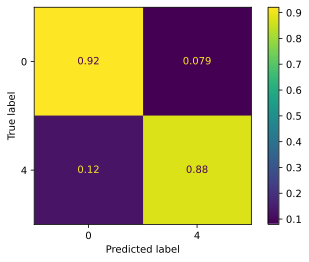

In [37]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot()

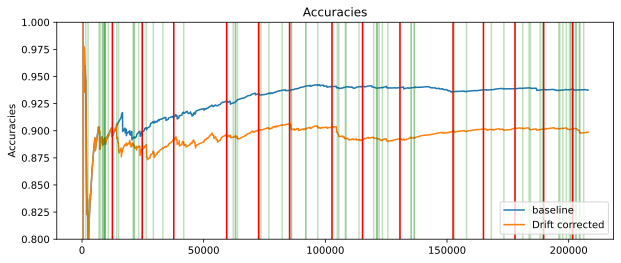

In [38]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_HDDM, 'baseline', 'Drift corrected')

### Comparación de detecciones de drift

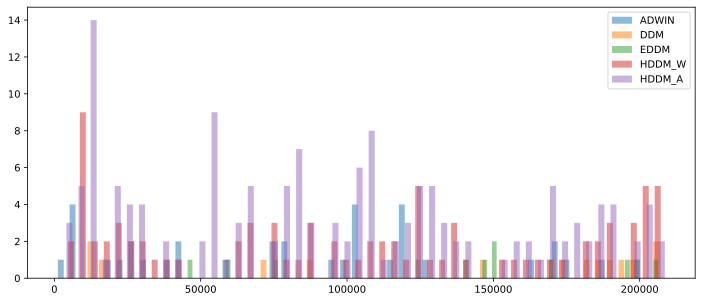

In [39]:
fig, ax = plt.subplots(figsize=(12,5))

res = dr_ADWIN.to_df()
ax.hist(res[res.change==True].i, bins=50, alpha=0.5, rwidth=0.5, align='left', label='ADWIN')
res = dr_DDM.to_df()
ax.hist(res[res.change==True].i, bins=50, alpha=0.5, rwidth=0.5, align='mid', label='DDM')
res = dr_EDDM.to_df()
ax.hist(res[res.change==True].i, bins=50, alpha=0.5, rwidth=0.5, align='mid', label='EDDM')
res = dr_HDDM.to_df()
ax.hist(res[res.change==True].i, bins=50, alpha=0.5, rwidth=0.5, align='right', label='HDDM_W')
res = dr_HDDM_A.to_df()
ax.hist(res[res.change==True].i, bins=50, alpha=0.5, rwidth=0.5, align='right', label='HDDM_A')
ax.legend()
plt.show()

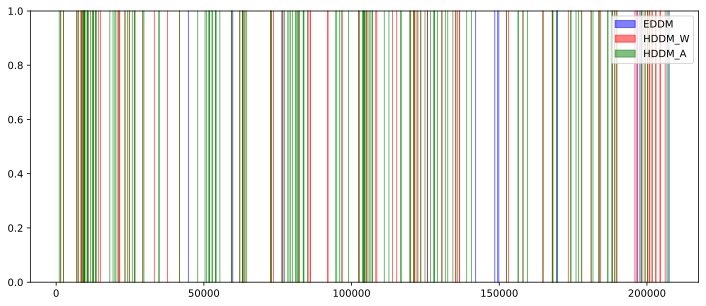

In [40]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12,5))

res = dr_EDDM.to_df()
for i in res[res.change==True].i:
    ax.axvline(x=i, c='blue', alpha=0.75, linewidth=0.75)
res = dr_HDDM.to_df()
for i in res[res.change==True].i:
    ax.axvline(x=i, c='red', alpha=0.75, linewidth=0.75)
res = dr_HDDM_A.to_df()
for i in res[res.change==True].i:
    ax.axvline(x=i, c='green', alpha=0.75, linewidth=0.75)

red_patch = mpatches.Patch(color='red', alpha=0.5, label='HDDM_W')
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='EDDM')
green_patch = mpatches.Patch(color='green', alpha=0.5, label='HDDM_A')
ax.legend(handles=[blue_patch, red_patch, green_patch], loc='upper right')
    
plt.show()